In [8]:
from keras.layers import Conv2D, BatchNormalization, Input, GlobalAveragePooling2D, Dense
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2DTranspose, Reshape

import pandas as pd
import os
from keras.optimizers import Adam

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


%matplotlib inline

In [44]:
from bs4 import BeautifulSoup
import requests
from re import sub

In [45]:


# function to convert string to camelCase
def camelCase(string):
  string = sub(r"(_|-)+", " ", string).title().replace(" ", "")
  return string[0].lower() + string[1:]

In [63]:

typeClass="col-md-10 col-md-offset-1 col-xs-12"
punk_html=requests.get('https://www.larvalabs.com/cryptopunks/details/635').text
soup = BeautifulSoup(punk_html, 'html.parser')
details = soup.find(id="punkDetails")

punkType = camelCase(details.find(class_=typeClass).find('a').contents[0])

attrs=[]
attrTags = details.find(class_ = "row detail-row")

    

['bandana', 'regularShades']

In [75]:
# build default attr dictionary
d={}
with open(f"{__ROOT_DIR__}/data/punx/list_attr_punx.csv") as f:
    for attr in f.read().split(','):
        d[attr]=-1
        

for attrTag in attrTags.find_all('a'):
    d[camelCase(attrTag.contents[0])]=1
d[punkType]=1 

In [73]:
__ROOT_DIR__ = "/home/david/artwork/zombiepunx"
IMAGE_DIR=f"{__ROOT_DIR__}/data/celeb/img_align_celeba/"
df = pd.read_csv('../data/celeb/list_attr_celeba.csv')
df['img_uri'] = IMAGE_DIR + df['image_id']

## load data and setup environment

In [11]:
__ROOT_DIR__ = "/home/david/artwork/zombiepunx"
IMAGE_DIR=f"{__ROOT_DIR__}/data/celeb/img_align_celeba/"
df = pd.read_csv('../data/celeb/list_attr_celeba.csv')
df['img_uri'] = IMAGE_DIR + df['image_id']


TOTAL_SAMPLES = df.shape[0]

SPATIAL_DIM = 24

# size of noise vector
LATENT_DIM_GAN = 100 

# filter size in conv layer
FILTER_SIZE = 5

# number of filters in conv layer
NET_CAPACITY = 16

# batch size
BATCH_SIZE_GAN = 32

# interval for displaying generated images
PROGRESS_INTERVAL = 80 

# directory for storing generated images
ROOT_DIR = '../viz'
if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)


In [12]:

# helper function for selecting 'size' real images
# and downscaling them to lower dimension SPATIAL_DIM
def sample_punks(df, size):
    samples = df.sample(frac=1).iloc[0:size]
    X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3))
    for i in range(0, size):
        file = samples.iloc[i]
        img_uri = file.img_uri
        img = cv2.imread(img_uri)
        img = np.flip(img, axis=2)
        img = img.astype(np.float32) / 127.5 - 1.0
        X[i] = img
    return X


# function for building the discriminator layers

In [13]:

def build_discriminator(start_filters, spatial_dim, filter_size):
    
    # function for building a CNN block for downsampling the image
    def add_discriminator_block(x, filters, filter_size):
      x = Conv2D(filters, filter_size, padding='same')(x)
      x = BatchNormalization()(x)
      x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(0.3)(x)
      return x
    
    # input is an image with shape spatial_dim x spatial_dim and 1 channels
    inp = Input(shape=(spatial_dim, spatial_dim, 1))

    # design the discrimitor to downsample the image 4x
    x = add_discriminator_block(inp, start_filters, filter_size)
    x = add_discriminator_block(x, start_filters * 2, filter_size)
    x = add_discriminator_block(x, start_filters * 4, filter_size)
    x = add_discriminator_block(x, start_filters * 8, filter_size)
    
    # average and return a binary output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=inp, outputs=x)

In [14]:

def build_generator(start_filters, filter_size, latent_dim):
  
  # function for building a CNN block for upsampling the image
  def add_generator_block(x, filters, filter_size):
      x = Conv2DTranspose(filters, filter_size, strides=2, padding='same')(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(0.3)(x)
      return x

  # input is a noise vector 
  inp = Input(shape=(latent_dim,))

  # projection of the noise vector into a tensor with 
  # same shape as last conv layer in discriminator
  x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
  x = BatchNormalization()(x)
  x = Reshape(target_shape=(4, 4, start_filters * 8))(x)

  # design the generator to upsample the image 4x
  x = add_generator_block(x, start_filters * 4, filter_size)
  x = add_generator_block(x, start_filters * 2, filter_size)
  x = add_generator_block(x, start_filters, filter_size)
  x = add_generator_block(x, start_filters, filter_size)    

  # turn the output into a 3D tensor, an image with 1 channels 
  x = Conv2D(1, kernel_size=5, padding='same', activation='tanh')(x)
  
  return Model(inputs=inp, outputs=x)

## build GAN from generator and discriminator

In [15]:
def construct_models(verbose=False):
    ### discriminator
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    # compile discriminator
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=Adam(lr=0.0002), 
                          metrics=['mae'])

    ### generator
    # do not compile generator
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM_GAN)

    ### DCGAN 
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False 
    gan.compile(loss='binary_crossentropy', 
                optimizer=Adam(lr=0.0002), 
                metrics=['mae'])

    if verbose: 
        generator.summary()
        discriminator.summary()
        gan.summary()
        
    return generator, discriminator, gan
  
(generator_punk, 
discriminator_punk,
gan_punk) = construct_models(verbose=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 64)          204864    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 64)          0   

# Training

In [16]:

# number of discriminator updates per alternating training iteration
DISC_UPDATES = 1  
# number of generator updates per alternating training iteration
GEN_UPDATES = 1 

# function for training the GAN

ref: https://towardsdatascience.com/generative-adversarial-network-gan-for-dummies-a-step-by-step-tutorial-fdefff170391

In [17]:
def run_training(generator, 
                 discriminator, 
                 gan, 
                 df, start_it=0, 
                 num_epochs=1000, 
                 get_real_images=sample_punks):
  # list for storing loss
  avg_loss_discriminator = []
  avg_loss_generator = []
  total_it = start_it

  # main training loop
  for epoch in range(num_epochs):

      # alternating training loop
      loss_discriminator = []
      loss_generator = []
      for it in range(200): 

          #### Discriminator training loop ####
          for i in range(DISC_UPDATES): 
              print(i)
              # select a random set of real images
              imgs_real = get_real_images(df, BATCH_SIZE_GAN)
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # generate a set of fake images using the generator
              imgs_fake = generator.predict(noise)
              # train the discriminator on real images with label 1
              d_loss_real = discriminator.train_on_batch(imgs_real, 
                                                         np.ones([BATCH_SIZE_GAN]))[1]
              # train the discriminator on fake images with label 0
              d_loss_fake = discriminator.train_on_batch(imgs_fake, 
                                                         np.zeros([BATCH_SIZE_GAN]))[1]

          # display some fake images for visual control of convergence
          if total_it % PROGRESS_INTERVAL == 0:
              plt.figure(figsize=(5,2))
              num_vis = min(BATCH_SIZE_GAN, 5)
              imgs_real = get_real_images(df, num_vis)
              noise = np.random.randn(num_vis, LATENT_DIM_GAN)
              imgs_fake = generator.predict(noise)
              for obj_plot in [imgs_fake, imgs_real]:
                  plt.figure(figsize=(num_vis * 3, 3))
                  for b in range(num_vis):
                      disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                      plt.subplot(1, num_vis, b + 1)
                      plt.title(str(round(disc_score, 3)))
                      plt.imshow(obj_plot[b] * 0.5 + 0.5) 
                  if obj_plot is imgs_fake:
                      plt.savefig(os.path.join(ROOT_DIR, 
                                               str(total_it).zfill(10) + '.jpg'), 
                                  format='jpg',
                                  bbox_inches='tight')
                  plt.show()  

          #### Generator training loop ####
          loss = 0
          y = np.ones([BATCH_SIZE_GAN, 1]) 
          for j in range(GEN_UPDATES):
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # train the generator on fake images with label 1
              loss += gan.train_on_batch(noise, y)[1]

          # store loss
          loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
          loss_generator.append(loss / GEN_UPDATES)
          total_it += 1

      # visualize loss
      clear_output(True)
      print('Epoch', epoch)
      avg_loss_discriminator.append(np.mean(loss_discriminator))
      avg_loss_generator.append(np.mean(loss_generator))
      plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
      plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
      plt.legend(['discriminator loss', 'generator loss'])
      plt.show()

  return generator, discriminator, gan


Epoch 4


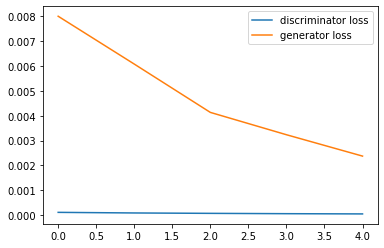

In [22]:

(generator_punk,
 discriminator_punk,
 gan_punk) = run_training(generator_punk,
                          discriminator_punk,
                          gan_punk,
                          num_epochs=5,
                          df=df)                                                 

In [21]:
generator_punk